### 1-D Richards equation solver code
- formulation based on a backward Euler implementation of the mixed theta-head formulation of the 1-D Richards equation, with a modified Picard iteration finite differencing solution scheme, with a modified Picard iteration finite differencing solution scheme.

- The soil water retention parameterization used is that of van Genuchten 
 [1980], and this code requires the corresponding MATLAB function        
 vanGenuchten.m.  
 
 - coordinate axis:  positive  upward
         z[-1] = zmax  (top)
         z[0] = 0  (bottom)

In [1]:
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')
import time

In [2]:
%matplotlib inline

In [3]:
def vanGenuchten(h,phi) :
    alpha   = phi[0]
    theta_S = phi[1]
    theta_R = phi[2]
    n       = phi[3]
    m       = phi[4]
    Ksat    = phi[5] 
    # Compute the volumetric moisture content
    theta = (theta_S - theta_R)/(1 + (alpha*abs(h))**n)**m + theta_R; 
    # Compute the effective saturation
    Se = ((theta - theta_R)/(theta_S - theta_R)); 
    # Compute the hydraulic conductivity
    K = Ksat*Se**(1./2)*(1 - (1 - Se**(1./m))**m)**2; 
    # Compute the specific moisture storage
    C =  -alpha*n*np.sign(h)*(1./n - 1)*(alpha*abs(h))**(n - 1)*(theta_R - 
         theta_S)*((alpha*abs(h))**n + 1)**(1/n - 2);
    try:
        for i in range(len(h)):
            if h[i] > 0:
                K[i] = Ksat
                C[i] = 0.
                theta[i] = theta_S
    except TypeError:
        if h > 0:
            K = Ksat
            C = 0.
            theta = theta_S
    return [C,K,theta]

In [10]:
# Define van Genuchten parameters
# Seal layer
sealAlpha   = 0.0078  
sealTheta_S = 0.450  
sealTheta_R = 0.0394  
sealLambdA  = 0.263  
sealn       = sealLambdA + 1
sealm       = sealLambdA/sealn
sealKsat    = 0.19/3600. 

vegAlpha   = 0.0096  
vegTheta_S = 0.472  
vegTheta_R = 0.0378  
vegLambdA  = 0.318 
vegn       = vegLambdA + 1
vegm       = vegLambdA/vegn
vegKsat    = 3.38/3600. 

# Store van Genuchten parameters in array  (seal layer)
sealphi = np.zeros(6)
sealphi[0] = sealAlpha
sealphi[1] = sealTheta_S
sealphi[2] = sealTheta_R
sealphi[3] = sealn
sealphi[4] = sealm
sealphi[5] = sealKsat

#  vegetation parameters / layer below seal
vegphi = np.zeros(6)
vegphi[0] = vegAlpha
vegphi[1] = vegTheta_S
vegphi[2] = vegTheta_R
vegphi[3] = vegn
vegphi[4] = vegm
vegphi[5] = vegKsat

In [54]:
alpha = np.ones(nz)*vegAlpha
theta_S = np.ones(nz)*vegTheta_S
theta_R = np.ones(nz)*vegTheta_R
alpha[si:] = sealAlpha
theta_S[si:] = sealTheta_S
theta_R[si:] = sealTheta_R

phi = {'alpha': alpha,'theta_R': theta_R,'theta_S': theta_S, }


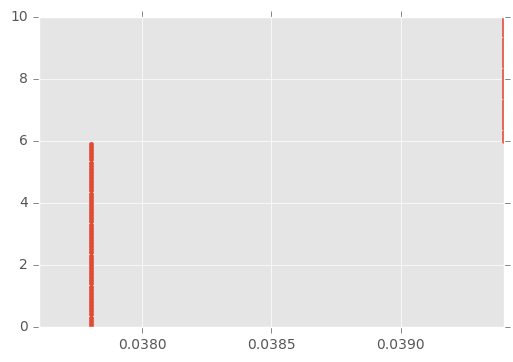

In [62]:
plt.plot( phi['theta_R'],z, '.')

In [63]:
# set up grid 
dz = .1; # [cm]
zmin = 0.; # [cm]
zmax = 10.; # [cm]
z =   np.arange(zmin, zmax+dz, dz)
nz = z.shape[0]
zs = -4.  # cm  
si =np.where(z == z[-1] + zs)[0][0]  # seal index

In [64]:
def make_matrices():
    # Define matrices that we'll need in solution
    DeltaPlus  = np.diag(-np.ones(nz)) + np.diag(np.ones(nz-1), 1)
    DeltaPlus[0,:] = 0
    DeltaPlus[nz-1,:] = 0

    DeltaMinus = np.diag(np.ones(nz)) + np.diag(-np.ones(nz-1),-1);
    DeltaMinus[0,:] = 0
    DeltaMinus[nz-1,:] = 0

    MPlus = np.diag(np.ones(nz))+np.diag(np.ones(nz-1),1)
    MPlus[0,0] = 2
    MPlus[0,1:nz-1] = 0
    MPlus[nz-1,nz-1] = 2
    MPlus[nz-1,:nz-1] = 0  # not needed

    MMinus = np.diag(np.ones(nz)) + np.diag(np.ones(nz-1),-1)
    MMinus[0,0] = 2
    MMinus[0,1:nz-1] = 0  # not needed
    MMinus[nz-1,nz-1] = 2
    MMinus[nz-1,:nz-1] = 0 
    
    return DeltaPlus, DeltaMinus, MPlus, MMinus

In [7]:
# Define time variables
stop_tol = 1e-7 # Stopping tolerance [cm]
dt  = .1 # [s]
tmin = 0. # [s]
tmax = 1000 # [s]

t = np.arange(tmin, tmax + dt, dt)
nt = t.shape[0]

In [ ]:
# ICs
case = 'rain'

if case == 'rain':
    setflux = 1
    prate = 1./3600
    # hinit = -100*np.ones(nz)
    hinit = - np.arange(nz)*dz
    fmtstr = 'dt={0}, tol={1}, p={2:.0e}'.format(dt, stop_tol, -prate)

if case == 'fixed_H':
    setflux = 0
    hinit = -1000*np.ones(nz)
    htop = -30.
    hinit[-1] = htop
    # hinit =   np.arange(nz)*5 - 500; htop = hinit[-1]
    fmtstr = 'dt={0}, tol={1}, htop={2}'.format(dt, stop_tol, htop)


In [ ]:
 def timestep(hnp1m, thetan, setflux = 1, flux = - prate, htop = 0., 
              stop_tol = stop_tol):
    """
    """
    stop_flag = 0
    niter = 0
    while(stop_flag == 0):
        # Layer S:
        [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1m,sealphi)
        Cdiag = np.diag(cnp1m) 
        kbarplus = (1/2.)*MPlus.dot(knp1m)
        Kbarplus = np.diag(kbarplus)
        kbarminus = (1/2.)*MMinus.dot(knp1m)
        Kbarminus = np.diag(kbarminus)
        A = (1./dt)*Cdiag - 1./((dz)**2)*(Kbarplus.dot(DeltaPlus) - 
                                          Kbarminus.dot(DeltaMinus)) 
        R_MPFD = (1./(dz**2))*(Kbarplus.dot(DeltaPlus).dot(hnp1m) - \
                               Kbarminus.dot(DeltaMinus).dot(hnp1m)) + \
             (1./dz)*(kbarplus - kbarminus) - (1./dt)*(thetanp1m - thetan) 
        deltam = np.linalg.pinv(A).dot(R_MPFD)
        niter = niter + 1
#         if niter > 100.:
#             stop_tol = stop_tol*10.
#             niter = 0
        if (max(abs(deltam[1:(nz-1)]))<stop_tol):
            stop_flag = 1
            hnp1mp1 = hnp1m + deltam 
            hnp1mp1[0] = hnp1mp1[1]  # free drainage BC
            if setflux == 1:
                [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1mp1,sealphi);
                kt = (knp1m[-2] + knp1m[-2])/2.
                hnp1mp1[-1] =  hnp1mp1[-2] - dz - flux*dz/kt
            else:
                hnp1mp1[-1] = htop
            [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1mp1,sealphi);
            knp1mp1 = knp1m
            cnp1mp1 = cnp1m            
            hnp1m = hnp1mp1
        else:        
            hnp1mp1 = hnp1m + deltam
            hnp1m = hnp1mp1
            hnp1m[0] = hnp1m[1] 
            if setflux == 1:
                [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1m,sealphi);
                kt = (knp1m[-2] + knp1m[-2])/2.
                hnp1m[-1] = hnp1m[-2] - dz - flux*dz/kt
            else:
                hnp1m[-1] = htop
    errornp1 =  np.sum(A.dot(deltam))*dt*dz
    
    return hnp1mp1,cnp1mp1,knp1mp1, thetanp1m, errornp1, niter, stop_tol

In [ ]:
 def pot_infl(hnp1m, thetan, htop = 0):
    """
    """
    stop_flag = 0
    niter = 0
    while(stop_flag == 0):
        [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1m,sealphi)
        Cdiag = np.diag(cnp1m) 
        kbarplus = (1/2.)*MPlus.dot(knp1m)
        Kbarplus = np.diag(kbarplus)
        kbarminus = (1/2.)*MMinus.dot(knp1m)
        Kbarminus = np.diag(kbarminus)
        A = (1./dt)*Cdiag - 1./((dz)**2)*(Kbarplus.dot(DeltaPlus) - 
                                          Kbarminus.dot(DeltaMinus)) 
        #  Compute the residual of MPFD (RHS)
        R_MPFD = (1./(dz**2))*(Kbarplus.dot(DeltaPlus).dot(hnp1m) - \
                               Kbarminus.dot(DeltaMinus).dot(hnp1m)) + \
             (1./dz)*(kbarplus - kbarminus) - (1./dt)*(thetanp1m - thetan); 
        # Compute deltam for iteration level m+1
        deltam = np.linalg.pinv(A).dot(R_MPFD)
        # Increment iteration counter and display number of iterations
        niter = niter + 1;
        if (max(abs(deltam[1:(nz-1)]))<stop_tol):
            stop_flag = 1
            hnp1mp1 = hnp1m + deltam 
            hnp1mp1[0] = hnp1mp1[1]  # free drainage BC
            hnp1mp1[-1] = htop
            [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1mp1,sealphi);
            knp1mp1 = knp1m
            cnp1mp1 = cnp1m            
            hnp1m = hnp1mp1
            PI = (knp1mp1[-2] + knp1mp1[-2])/2.*((hnp1mp1[-1] - hnp1mp1[-2])/dz + 1.)
        else:
            hnp1mp1 = hnp1m + deltam
            hnp1m = hnp1mp1
            hnp1m[0] = hnp1m[1] 
            hnp1m[-1] = htop
    return PI

In [ ]:
if setflux == 1:
    [Cinit,Kinit,thetainit] = vanGenuchten(hinit,sealphi) 
    kt = (Kinit[-2] + Kinit[-2])/2.
    PI = pot_infl(hinit, thetainit, htop = 0)
    hinit[-1] = hinit[-2] - dz + PI*dz/kt

# use output from previous run:
# hinit = hnp1mp1

# Define a storage container to store the pressure heads and soil moistures
[Cinit,Kinit,thetainit] = vanGenuchten(hinit,sealphi) 
H = np.zeros([nz,nt])
K = np.zeros([nz,nt])
C = np.zeros([nz,nt])
H[:,0] = hinit
K[:,0] = Kinit
C[:,0] = Cinit

THETA = np.zeros([nz,nt])
THETA[:,0] = thetainit
ktop = np.zeros([ nt])
kbot = np.zeros([ nt])
error = np.zeros([nt])


In [ ]:
depth = 0.
# setflux = 1
start_time = time.time()
iterations = np.zeros([nt]);  # Define array for iteration counter
new_tol = np.zeros([nt]);

for i in range(1, nt):   # Initialize the Picard iteration solver
 
    hnp1m =  H[:,i-1]  
    thetan = THETA[:,i-1]
    
    if depth <= 0:
        PI = pot_infl(hnp1m, thetan, htop = 0)
        print i, 'PI = {0:.2f}cm/hr; rain = {1:.2f}cm/hr; t = {2:.2f}'.format(
            PI*3600,prate*3600, t[i])
        if  PI < prate:
            flux = - PI
            print 'ponding'
        else:
            flux = - prate
            
    if depth <= 0:
        #  setflux = 1
        hnp1mp1,cnp1mp1,knp1mp1, thetanp1mp1,errornp1,niter, tol = \
           timestep(hnp1m,thetan,  setflux = 1, flux = flux)
        depth += prate*dt + flux*dt
        
    else:
        #   setflux = 0
        hnp1mp1,cnp1mp1,knp1mp1, thetanp1mp1, errornp1,niter, tol = \
                        timestep(hnp1m,thetan,  setflux = 0, htop = depth)
        infl =  (knp1mp1[-1] + knp1mp1[-2])/2.*((hnp1mp1[-1] - hnp1mp1[-2])/dz + 1.)*dt 

        #  kt = (knp1mp1[-2] + knp1mp1[-2])/2.       
        # PI =  pot_infl(hnp1m, thetan, htop = 0)
        #  print PI/(kt*((hnp1mp1[-1] - hnp1mp1[-2])/dz + 1.))
        depth +=  prate*dt - kt*((hnp1mp1[-1] - hnp1mp1[-2])/dz + 1.)*dt 
    
    if np.mod(i,100) == 0:
         print i, 'depth = {0:.2f}cm; rain = {1:.2f} cm/hr'.format(depth,prate*3600)
    THETA[:,i] = thetanp1mp1
    H[:,i] = hnp1mp1
    K[:, i]= knp1mp1
    C[:,i] = cnp1mp1
    kbot[i] =  (K[0, i] + K[1, i])/2.  
    ktop[i] =  (K[-1, i] + K[-2, i])/2.  
    error[i] = errornp1
    new_tol[i] = tol
#    error[i] = dz*np.sum(C[:,i]*deltam[:]) +  kbot[i]*(deltam[1] - deltam[0])*dt/dz \
#           ktop[i]*(deltam[-1] - deltam[-2])*dt/dz
    iterations[i] = niter
    

fluxin =    ktop*((H[-1] - H[-2])/dz + 1.)*dt   # top flux (cm)
fluxout = - kbot*((H[1] - H[0])/dz + 1. )*dt # bottom flux (cm)
newmass = (THETA[:, 1:] - THETA[:, :-1]).sum(0)   #  change in mass 

print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
depth

In [38]:
# depth = 0.
# start_time = time.time()
# iterations = np.zeros([nt-1]);  # Define array for iteration counter

# for i in range(1, nt):   # Initialize the Picard iteration solver
#     if np.mod(i,1000) == 0:
#         print i, 'PI =  {0:.2f}cm/hr ; rain =  {1:.2f} cm/hr, t = {2:.2f}'.format(PI*3600,- prate*3600, t[i])
#     hnp1m =  H[:,i-1]  
#     thetan = THETA[:,i-1]
#     PI = pot_infl(hnp1m, thetan, htop = depth)
# #     print 'pot infl = ',  PI
#     if  PI < abs(prate):
#         flux = - PI
#         depth += abs(prate*dt) - PI
#     else:
#         flux = prate
#     hnp1mp1,cnp1mp1,knp1mp1, thetanp1mp1,errornp1, niter = timestep(hnp1m,thetan, 
#                                                     setflux = True, flux = flux)

#     THETA[:,i] = thetanp1mp1
#     H[:,i] = hnp1mp1
#     K[:, i]= knp1mp1
#     C[:,i] = cnp1mp1
#     kbot[i] =  (K[0, i] + K[1, i])/2.  
#     ktop[i] =  (K[-1, i] + K[-2, i])/2.  
#     error[i] = errornp1
# #    error[i] = dz*np.sum(C[:,i]*deltam[:]) +  kbot[i]*(deltam[1] - deltam[0])*dt/dz \
# #           ktop[i]*(deltam[-1] - deltam[-2])*dt/dz
#     iterations[i-1] = niter

#     if np.mod(i,10) == 0:
#         print t[i],  depth #(knp1mp1[-1] + knp1mp1[-2])/2.*((hnp1mp1[-1] - hnp1mp1[-2])/dz + 1.)*dt 
        
# fluxin =    ktop*((H[-1] - H[-2])/dz + 1.)*dt   # top flux (cm)
# fluxout = - kbot*((H[1] - H[0])/dz + 1. )*dt # bottom flux (cm)
# newmass = (THETA[:, 1:] - THETA[:, :-1]).sum(0)   #  change in mass 

# print("--- %s seconds ---" % (time.time() - start_time))

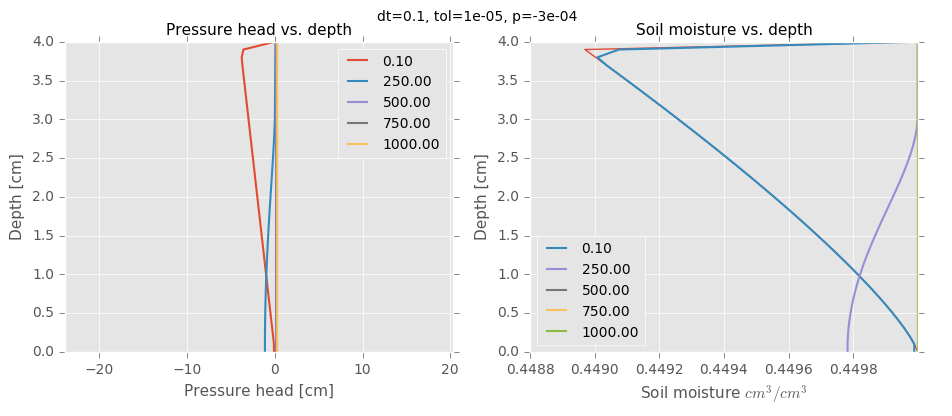

In [39]:
# 1. profile
fig = plt.figure(1, figsize = (11,4)); 
ax = plt.subplot(121)
plt.xlabel('Pressure head [cm]',fontsize=  11)
plt.plot(H[:, 1],z, label = '{0:.2f}'.format(t[1]), lw = 1.5)
plt.ylabel('Depth [cm]',fontsize=  11)
plt.xlim( np.min(H)-20,  np.max(H)+20)
plt.title('Pressure head vs. depth', fontsize=  11)

ax = plt.subplot(122)
plt.plot(thetainit,z)
plt.xlabel('Soil moisture $cm^3/cm^3$',fontsize=  11)
plt.ylabel('Depth [cm]',fontsize=  11)
plt.plot(THETA[:, 1],z, label = '{0:.2f}'.format(t[1]), lw = 1.5)
plt.title('Soil moisture vs. depth',fontsize=  11)

for i in  range(len(t)/4, len(t), len(t)/4):
    ax = plt.subplot(121)
    plt.plot(H[:, i],z, label = '{0:.2f}'.format(t[i]), lw = 1.5)
    plt.legend(loc = 'best', fontsize = 10)
    ax = plt.subplot(122)
    plt.plot(THETA[:, i],z, label = '{0:.2f}'.format(t[i]), lw = 1.5)
    plt.legend(loc = 'best', fontsize = 10)
    
plt.suptitle(fmtstr)
fig.savefig('case_{1}/profile {0}.pdf'.format(fmtstr, case))

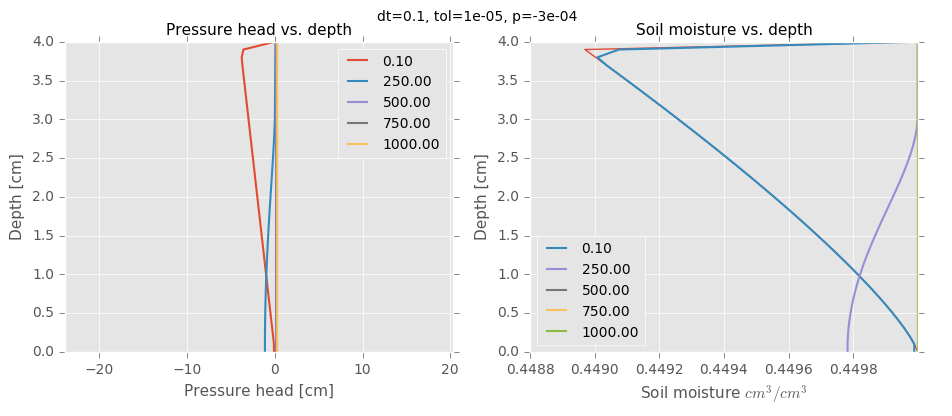

In [40]:
# 1. profile
fig = plt.figure(1, figsize = (11,4)); 
ax = plt.subplot(121)
plt.xlabel('Pressure head [cm]',fontsize=  11)
plt.plot(H[:, 1],z, label = '{0:.2f}'.format(t[1]), lw = 1.5)
plt.ylabel('Depth [cm]',fontsize=  11)
plt.xlim( np.min(H)-20,  np.max(H)+20)
plt.title('Pressure head vs. depth', fontsize=  11)

ax = plt.subplot(122)
plt.plot(thetainit,z)
plt.xlabel('Soil moisture $cm^3/cm^3$',fontsize=  11)
plt.ylabel('Depth [cm]',fontsize=  11)
plt.plot(THETA[:, 1],z, label = '{0:.2f}'.format(t[1]), lw = 1.5)
plt.title('Soil moisture vs. depth',fontsize=  11)

for i in  range(len(t)/4, len(t), len(t)/4):
    ax = plt.subplot(121)
    plt.plot(H[:, i],z, label = '{0:.2f}'.format(t[i]), lw = 1.5)
    plt.legend(loc = 'best', fontsize = 10)
    ax = plt.subplot(122)
    plt.plot(THETA[:, i],z, label = '{0:.2f}'.format(t[i]), lw = 1.5)
    plt.legend(loc = 'best', fontsize = 10)
    
plt.suptitle(fmtstr)
fig.savefig('case_{1}/profile {0}.pdf'.format(fmtstr, case))

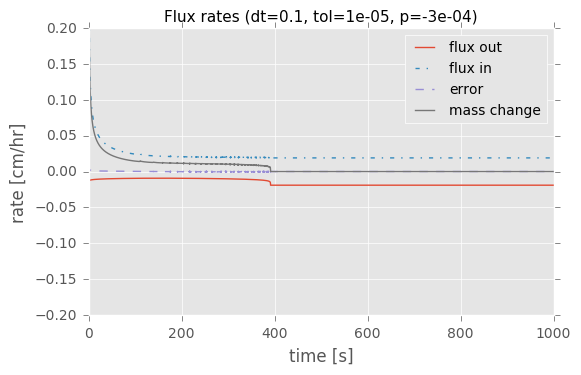

In [48]:
# 2. flux rates
fig = plt.figure(1, figsize = (6,3.7))

plt.title('Flux rates ({0})'.format(fmtstr), fontsize = 11)
plt.plot(t[1:], fluxout[1:]/dt*3600, label = 'flux out')
plt.plot(t[1:], fluxin[1:]/dt*3600, '-.', ms = 4, label = 'flux in')
plt.plot(t[1:], error[1:]/dt*3600, '--',  label = 'error')
plt.plot(t[2:], newmass[1:]*dz/dt*3600, label = 'mass change')
plt.legend(loc = 'best', fontsize = 10)
plt.ylim(-.2,.2)
plt.xlabel('time [s]') 
plt.ylabel('rate [cm/hr]')
fig.savefig('case_{1}/flux rates {0}.pdf'.format(fmtstr, case) )

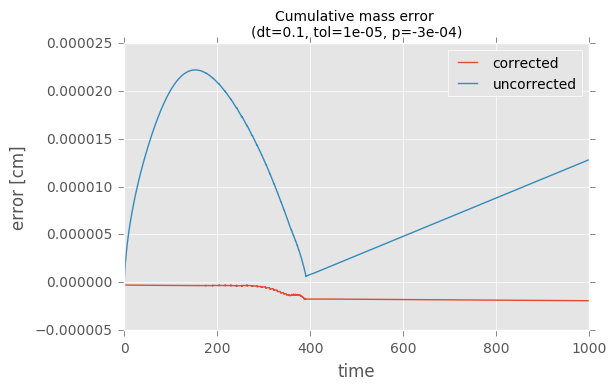

In [44]:
# 3.  cumulative error
fig = plt.figure(1, figsize = (6,3.7))
plt.title('Cumulative mass error \n({0})'.format(fmtstr), fontsize = 10)
plt.plot(t[2:], np.cumsum(fluxin[2:] - newmass[1:]*dz + fluxout[2:] - error[2:] ), label =  'corrected')
plt.plot(t[2:], np.cumsum(fluxin[2:] -  newmass[1:]*dz +fluxout[2:]  ), label = 'uncorrected')
plt.xlabel('time')
plt.ylabel('error [cm]')
plt.legend(loc = 'best', fontsize = 10)
fig.savefig('case_{1}/error {0}.pdf'.format(fmtstr, case))

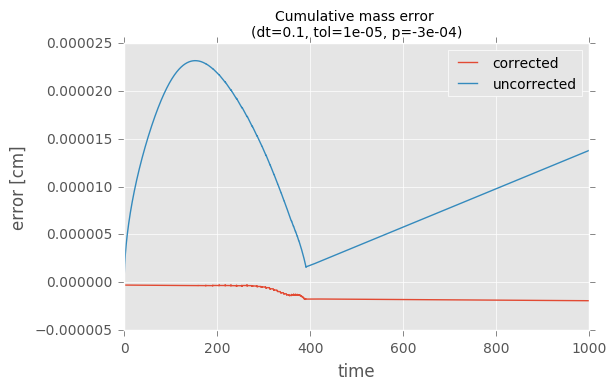

In [45]:
# 3.  cumulative error
fig = plt.figure(1, figsize = (6,3.7))
plt.title('Cumulative mass error \n({0})'.format(fmtstr), fontsize = 10)
plt.plot(t[1:], np.cumsum(fluxin[1:] - newmass*dz + fluxout[1:] - error[1:] ), label =  'corrected')
plt.plot(t[1:], np.cumsum(fluxin[1:] -  newmass*dz +fluxout[1:]  ), label = 'uncorrected')
plt.xlabel('time')
plt.ylabel('error [cm]')
plt.legend(loc = 'best', fontsize = 10)
fig.savefig('case_{1}/error {0}.pdf'.format(fmtstr, case))

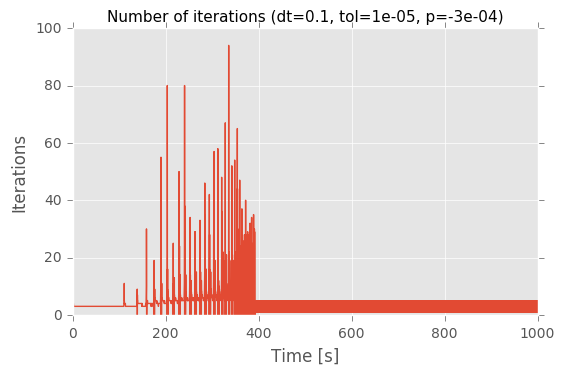

In [46]:
# 4. Number of iterations
fig = plt.figure(1, figsize = (6,3.7))
plt.plot(t[1:],iterations[1:],'-')
plt.xlabel('Time [s]')
plt.title('Number of iterations ({0})'.format(fmtstr), fontsize = 11)
plt.ylabel('Iterations')
fig.savefig('case_{1}/iterations {0}.pdf'.format(fmtstr, case))

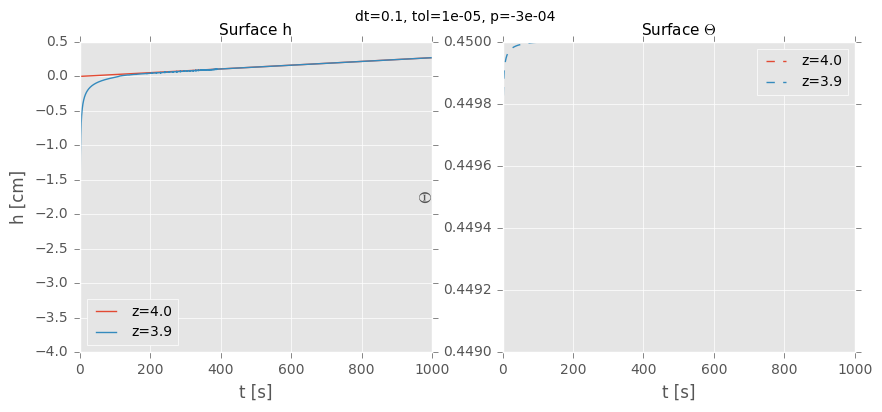

In [47]:
fig  = plt.figure(1, figsize = (10,4)); 
ax = plt.subplot(121)
plt.title('Surface h',  fontsize = 11)
plt.plot(t[1:], H[-1, 1:], label = 'z={}'.format(z[-1]))
plt.plot(t[1:], H[-2, 1:], label = 'z={}'.format(z[-2]))
plt.xlabel('t [s]'); plt.ylabel('h [cm]')
plt.legend(loc = 'best', fontsize = 10)
ax = plt.subplot(122)
plt.title('Surface $\Theta$',  fontsize = 11)
plt.plot(t[1:], THETA[-1, 1:], '--', label = 'z={}'.format(z[-1]))
plt.plot(t[1:], THETA[-2, 1:], '--', label = 'z={}'.format(z[-2]))
plt.legend(loc = 'best', fontsize = 10)
plt.xlabel('t [s]'); plt.ylabel('$\Theta$')
plt.suptitle('{}'.format(fmtstr))
fig.savefig('case_{1}/surface_{0}.pdf'.format(fmtstr, case))

    Chen 2012 parameters

In [56]:
rho = 1.48  # g cm-3
alphav = 0.0078*(rho/1.48)**-3.72
n = (3.733*rho - 3.644)**0.845

In [57]:
n

1.7054041492009087

The aim of this study is to investigate the roles that surface seal layer, microtopogrpahy and vegetation play in the rainfall-infiltration-runoff process a